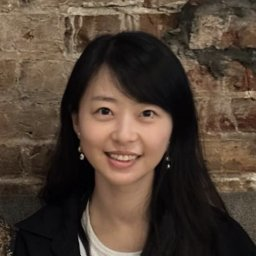

# Huiwen Chang
# Researcher, OpenAI

# MaskGIT: Masked Generative Image Transformer

# https://arxiv.org/pdf/2202.04200

## Abstract

MaskGIT introduces a non-autoregressive image generation paradigm based on a bidirectional Transformer trained with masked visual token modeling. Instead of decoding images sequentially, the model predicts all image tokens in parallel and iteratively refines them using a scheduled masking strategy. This design dramatically accelerates image generation while maintaining high visual quality and diversity, and it naturally supports flexible image editing tasks.

---

## Problems

1. **Inefficiency of autoregressive decoding**  
   Sequential token generation causes very slow inference, especially for high-resolution images.

2. **Suboptimal image modeling**  
   Raster-ordered, one-dimensional tokenization ignores the inherently two-dimensional and global structure of images.

3. **Limited flexibility in editing tasks**  
   Autoregressive transformers are poorly suited for inpainting, outpainting, and region-based manipulation.

---

## Proposed Solutions

- Introduce a **Masked Generative Image Transformer** with bidirectional self-attention instead of autoregressive decoding.
- Train using **Masked Visual Token Modeling (MVTM)**, analogous to masked language modeling.
- Apply **scheduled parallel decoding**, where all tokens are predicted simultaneously and iteratively refined based on confidence.

---

## Purpose

The paper aims to show that masked modeling with bidirectional Transformers can replace autoregressive and GAN-based image generation, achieving faster inference, strong sample quality, improved diversity, and flexible image manipulation within a single unified framework.

---

## Methodology

### Architecture (Two Stages)

1. **Tokenization stage**  
   Images are encoded into discrete visual tokens using a VQGAN-style tokenizer.

2. **Transformer stage**  
   A bidirectional Transformer is trained to predict randomly masked tokens via MVTM.

### Iterative Decoding

- Initialize with all tokens masked.
- At each iteration:
  - Predict all tokens in parallel.
  - Keep the most confident predictions.
  - Remask the remaining tokens.
- Gradually decrease the mask ratio using a predefined schedule (cosine schedule performs best).

### Training Objective

Minimize the negative log-likelihood of masked tokens using cross-entropy loss:
$$
\mathcal{L} = - \mathbb{E}_{x, m} \sum_{i \in m} \log p_\theta(x_i \mid x_{\setminus m}),
$$
where \( m \) denotes the set of masked token positions.

---

## Results

- **Speed**  
  Up to \(64\times\) faster decoding than autoregressive transformer models.

- **Image Quality**  
  Matches or exceeds GANs and diffusion models on ImageNet at \(256 \times 256\) and \(512 \times 512\) resolutions in terms of FID and Inception Score.

- **Diversity**  
  Achieves state-of-the-art Classification Accuracy Score, indicating strong mode coverage.

- **Flexibility**  
  Performs competitively on inpainting, outpainting, and class-conditional image editing without task-specific architectural changes.

---

## Conclusions

MaskGIT establishes masked modeling with bidirectional Transformers as a powerful alternative for image generation. By combining parallel decoding, iterative refinement, and effective masking schedules, it overcomes the inefficiency of autoregressive models while retaining stable training and high sample quality. The approach bridges likelihood-based models and GANs, opening a path toward fast, flexible, and scalable generative vision systems.


# Mathematics of MaskGIT: Masked Generative Image Transformer

---

## 1. Discrete Latent Representation (Tokenization)

### Mathematical Idea

Images are **not** modeled directly in pixel space.  
Instead, an image is compressed into a grid of **discrete latent tokens** using a vector-quantized autoencoder.

Given an image:
$$
x \in \mathbb{R}^{H \times W \times 3},
$$
an encoder maps it to latent embeddings, which are then **quantized** to the nearest codebook vectors.

The result is a grid (or sequence) of discrete tokens:
$$
Y = \{y_i\}_{i=1}^{N}, \qquad y_i \in \{1,2,\dots,K\},
$$
where:
- $N = h \times w$ is the number of visual tokens,
- $K$ is the size of the codebook.

### Role in MaskGIT

This transformation converts image generation into **discrete probability modeling**, enabling:
- categorical likelihoods,
- Transformer-based modeling,
- avoidance of continuous density estimation in pixel space.

---

## 2. Masked Visual Token Modeling (MVTM)

### Masking Process

Define a binary mask:
$$
M = \{m_i\}_{i=1}^{N}, \qquad m_i \in \{0,1\},
$$
where:
- $m_i = 1$ indicates a **masked** token,
- $m_i = 0$ indicates a **visible** token.

Masked tokens are replaced by a special `[MASK]` symbol.

---

### Training Objective (Core Equation)

The training loss is the **negative log-likelihood of masked tokens only**:
$$
\mathcal{L}_{\text{mask}}
=
- \mathbb{E}_{Y \sim \mathcal{D}}
\left[
\sum_{i : m_i = 1}
\log p_\theta\left(y_i \mid Y_M\right)
\right],
$$
where:
- $Y_M$ is the masked token sequence,
- $p_\theta(y_i \mid Y_M)$ is predicted by a **bidirectional Transformer**.

### Explanation

- The model learns to **predict missing tokens** from visible context.
- Only masked positions contribute to the loss.
- This corresponds to **maximum likelihood estimation** for discrete variables.

### Role in the Paper

This replaces the autoregressive factorization:
$$
p(y_1,\dots,y_N) = \prod_{i=1}^{N} p(y_i \mid y_{<i}),
$$
with a **bidirectional conditional likelihood**, enabling **parallel prediction**.

---

## 3. Bidirectional Conditional Probability

Instead of modeling:
$$
p(y_i \mid y_1,\dots,y_{i-1}),
$$
MaskGIT models:
$$
p(y_i \mid Y \setminus i),
$$
meaning each token is predicted using **all other visible tokens**, not just previous ones.

### Role

- Enables parallel inference,
- Exploits global image context,
- Aligns better with the two-dimensional structure of images.

---

## 4. Iterative Parallel Decoding (Inference Algorithm)

### Initialization

At inference time:
$$
Y^{(0)} = \text{all tokens masked}.
$$

---

### Iterative Refinement

For iterations $t = 0, \dots, T-1$:

1. **Predict probabilities**
$$
p_i^{(t)} \in \mathbb{R}^K.
$$

2. **Sample tokens**
$$
y_i^{(t)} \sim p_i^{(t)}.
$$

3. **Assign confidence**
$$
c_i = \max_k p_i^{(t)}(k).
$$

4. **Mask scheduling**
$$
n_t = \left\lceil \gamma\!\left(\frac{t}{T}\right) \cdot N \right\rceil.
$$

5. **Remask** the least confident tokens.

---

### Mask Scheduling Function

The schedule $\gamma : [0,1] \to [0,1]$ satisfies:
$$
\gamma(0) = 1, \qquad \gamma(1) = 0,
$$
and is monotonic decreasing.

Best-performing choice:
$$
\gamma(r) = \cos\!\left(\frac{\pi r}{2}\right).
$$

### Interpretation

- Early iterations predict only highly confident tokens,
- Later iterations refine fine details,
- This induces a **coarse-to-fine generation process**.

---

## 5. Optimization and Training Statistics

- **Loss**: categorical cross-entropy  
- **Optimizer**: Adam  
- **Regularization**:
  - Dropout
  - Label smoothing  

No adversarial loss, no diffusion SDEs, no ELBOs.

### Key Mathematical Distinction

Training is **pure likelihood maximization**, unlike:
- GANs (min–max optimization),
- Diffusion models (variational bounds).

---

## 6. Statistical Evaluation Metrics

### 6.1 Fréchet Inception Distance (FID)

$$
\text{FID}
=
\|\mu_r - \mu_g\|^2
+
\operatorname{Tr}
\left(
\Sigma_r + \Sigma_g
- 2(\Sigma_r \Sigma_g)^{1/2}
\right),
$$
where $(\mu_r,\Sigma_r)$ and $(\mu_g,\Sigma_g)$ are feature statistics of real and generated images.

- Measures distributional similarity,
- Lower is better.

---

### 6.2 Inception Score (IS)

$$
\exp
\left(
\mathbb{E}_x
\left[
\mathrm{KL}\big(p(y \mid x) \,\|\, p(y)\big)
\right]
\right).
$$

- Encourages confident predictions,
- Encourages class diversity.

---

### 6.3 Precision and Recall

- **Precision**: sample realism,
- **Recall**: mode coverage.

Computed in feature space using nearest-neighbor statistics.

---

### 6.4 Classification Accuracy Score (CAS)

Procedure:
1. Train a classifier on generated samples only,
2. Evaluate it on real validation data.

Interpretation:
High accuracy implies strong **distributional faithfulness**.

---

## 7. Reconstruction Statistics

- **PSNR** (Peak Signal-to-Noise Ratio),
- **LPIPS** (Perceptual similarity).

Used to analyze redundancy and masking behavior.

### Key Observation

Even with approximately **90% of tokens masked**, MaskGIT reconstructs global structure accurately, revealing strong redundancy in discrete image tokens.

---

## Final Mathematical Perspective

MaskGIT introduces **no new probability distribution**, but a new **factorization and inference strategy**:

- Likelihood-based,
- Discrete,
- Bidirectional,
- Iterative refinement instead of sequential sampling.

Mathematically, it lies between:
- Autoregressive models (exact likelihood, slow),
- Diffusion models (iterative but continuous),
- GANs (implicit distributions, unstable).


## Key Problems, Limitations of Prior Work, and MaskGIT’s Solutions

| Key problems / research gaps identified | How these issues limit prior work | How MaskGIT proposes to solve them |
|----------------------------------------|----------------------------------|-----------------------------------|
| **GAN-based image synthesis suffers from training instability and mode collapse** | Even when GANs generate high-fidelity images quickly, adversarial min–max optimization often leads to instability and mode collapse, reducing distribution coverage and sample diversity. Robustness and diversity remain unresolved. | Move to a **likelihood-trained, token-based generative framework** that avoids adversarial training altogether, enabling stable optimization and improved coverage of the data distribution. |
| **Generative Transformers for images rely on autoregressive decoding** | Sequential token generation is inherently non-parallelizable and becomes prohibitively slow for images, where token sequences are far longer than in language modeling (e.g., hundreds or thousands of tokens). | Replace autoregressive decoding with **Masked Visual Token Modeling (MVTM)** using a bidirectional Transformer, allowing tokens to be predicted in parallel and dramatically accelerating inference. |
| **Images are treated as naive 1D raster-ordered sequences** | Raster-order factorization restricts conditional context to a single direction during generation and fails to exploit the rich, global structure of images. | Use **bidirectional conditional modeling**, where masked tokens are predicted using all visible tokens via bidirectional self-attention, enabling global context utilization aligned with image structure. |
| **Fixed low mask ratios (e.g., 15% in BERT) are unsuitable for image generation** | Fixed masking does not reflect the inference scenario of generating images from a blank canvas, creating a train–test mismatch for synthesis from scratch. | Introduce a **mask scheduling function** \( \gamma \) that varies the mask ratio, satisfying \( \gamma(0)=1 \) and \( \gamma(1)=0 \), enabling convergence from fully masked to fully specified token grids. |
| **One-pass parallel prediction is theoretically possible but practically unreliable** | A single-step prediction is inconsistent with training conditions and often produces incoherent images because the model is not trained for full synthesis in one pass. | Employ **iterative parallel decoding**: repeatedly predict masked tokens, retain high-confidence predictions, re-mask low-confidence ones, and gradually reduce the mask ratio until completion. |
| **Lack of a unified mechanism for image editing tasks** | Many prior generators focus on unconditional synthesis; extending them to inpainting, outpainting, or manipulation often requires specialized objectives, architectures, or inference pipelines. | Leverage MaskGIT’s **masking-based formulation**, where edited regions are simply treated as masked tokens and regenerated conditioned on unmasked context, enabling flexible editing without architectural changes. |


In [1]:
# MaskGIT-Style Lab (Single Cell)
# ==========================================
import math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 0) Reproducibility + Device
# ----------------------------
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# ----------------------------
# 1) Data (MNIST) - small subset
# ----------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="/mnt/data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="/mnt/data", train=False, download=True, transform=transform)

train_subset = Subset(train_ds, range(0, 12000))  # keep it small for quick lab runs
test_subset  = Subset(test_ds,  range(0, 2000))

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.72MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


In [4]:
# ---------------------------------------
# 2) VQ Tokenizer (Tiny VQ-VAE Components)
# ---------------------------------------
# Goal: Turn images into a small grid of discrete IDs ("visual tokens")
# Then decode IDs back to pixels for visualization / reconstruction.

class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer.
    Inputs: continuous latent z_e (B, D, H, W)
    Outputs:
      - z_q_st: quantized latent with straight-through estimator
      - idx_grid: discrete token IDs (B, H, W)
      - vq_loss: codebook + commitment loss
    """
    def __init__(self, K=256, D=64, beta=0.25):
        super().__init__()
        self.K = K
        self.D = D
        self.beta = beta
        self.codebook = nn.Embedding(K, D)
        nn.init.uniform_(self.codebook.weight, -1.0 / K, 1.0 / K)

    def forward(self, z_e):
        B, D, H, W = z_e.shape
        z = z_e.permute(0, 2, 3, 1).contiguous()    # (B, H, W, D)
        z_flat = z.view(-1, D)                      # (B*H*W, D)

        # Compute squared L2 distances to codebook embeddings
        # dist = ||x||^2 + ||e||^2 - 2 x·e
        e = self.codebook.weight                    # (K, D)
        dist = (z_flat.pow(2).sum(1, keepdim=True)
                + e.pow(2).sum(1)
                - 2 * z_flat @ e.t())               # (B*H*W, K)

        idx = dist.argmin(dim=1)                    # (B*H*W,)
        z_q = self.codebook(idx).view(B, H, W, D)   # (B, H, W, D)
        z_q = z_q.permute(0, 3, 1, 2).contiguous()  # (B, D, H, W)

        # VQ losses
        codebook_loss = F.mse_loss(z_q, z_e.detach())
        commit_loss   = F.mse_loss(z_e, z_q.detach())
        vq_loss = codebook_loss + self.beta * commit_loss

        # Straight-through estimator (copy gradients from z_e to z_q)
        z_q_st = z_e + (z_q - z_e).detach()
        idx_grid = idx.view(B, H, W)
        return z_q_st, idx_grid, vq_loss

class TinyVQVAE(nn.Module):
    """
    Tiny VQ-VAE-style tokenizer:
      - Encoder downsamples 28x28 -> 7x7 latent grid (downsample factor 4)
      - VQ quantizes each latent position to a discrete code
      - Decoder upsamples 7x7 -> 28x28
    """
    def __init__(self, K=256, D=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),   # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 14 -> 7
            nn.ReLU(),
            nn.Conv2d(64, D, 1)          # -> D channels
        )
        self.vq = VectorQuantizer(K=K, D=D, beta=0.25)
        self.dec = nn.Sequential(
            nn.Conv2d(D, 64, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7 -> 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 14 -> 28
            nn.Sigmoid()
        )

    @torch.no_grad()
    def encode_tokens(self, x):
        z_e = self.enc(x)
        _, idx_grid, _ = self.vq(z_e)
        return idx_grid  # (B, 7, 7)

    def forward(self, x):
        z_e = self.enc(x)
        z_q_st, idx_grid, vq_loss = self.vq(z_e)
        x_hat = self.dec(z_q_st)
        recon_loss = F.mse_loss(x_hat, x)
        loss = recon_loss + vq_loss
        return x_hat, idx_grid, loss, recon_loss.detach(), vq_loss.detach()

In [5]:
# --------------------------------------------
# 3) MaskGIT Transformer (Bidirectional Tokens)
# --------------------------------------------
# MVTM training: randomly mask tokens, predict masked positions using bidirectional self-attention.

class MaskGITTransformer(nn.Module):
    """
    Bidirectional Transformer over token sequence.
    Input tokens are IDs in [0..K] where K is the special [MASK] token.
    Output is logits over [0..K-1] (real tokens).
    """
    def __init__(self, vocab_size, seq_len, d_model=256, nhead=8, num_layers=6, num_classes=10):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.mask_id = vocab_size  # reserve vocab_size as [MASK]

        self.token_emb = nn.Embedding(vocab_size + 1, d_model)  # +1 for [MASK]
        self.pos_emb   = nn.Embedding(seq_len, d_model)
        self.class_emb = nn.Embedding(num_classes, d_model)     # simple class conditioning

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=0.1, batch_first=True, activation="gelu"
        )
        self.tr = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, token_ids, class_ids):
        B, N = token_ids.shape
        pos = torch.arange(N, device=token_ids.device).unsqueeze(0).expand(B, N)
        x = self.token_emb(token_ids) + self.pos_emb(pos)
        x = x + self.class_emb(class_ids).unsqueeze(1)  # broadcast class conditioning
        x = self.tr(x)
        x = self.ln(x)
        logits = self.head(x)  # (B, N, vocab_size)
        return logits

In [6]:
# --------------------------------------------
# 4) Masking utilities + MaskGIT decoding
# --------------------------------------------
def make_random_mask(token_ids, mask_id, min_ratio=0.15, max_ratio=0.95):
    """
    Randomly mask a fraction of tokens for each sample.
    Returns: masked_tokens, mask_boolean (True where masked)
    """
    B, N = token_ids.shape
    ratios = torch.empty(B, device=token_ids.device).uniform_(min_ratio, max_ratio)
    masked = token_ids.clone()
    mask = torch.zeros((B, N), device=token_ids.device, dtype=torch.bool)
    for i in range(B):
        n_mask = int(round(ratios[i].item() * N))
        idx = torch.randperm(N, device=token_ids.device)[:n_mask]
        mask[i, idx] = True
        masked[i, idx] = mask_id
    return masked, mask

def cosine_schedule(r):
    """
    Cosine schedule for mask ratio. r in [0,1].
    At r=0 -> 1 (mask everything), at r=1 -> 0 (mask nothing).
    """
    return math.cos(math.pi * r / 2)

@torch.no_grad()
def maskgit_generate(model, seq_len, vocab_size, class_id, num_samples=16, steps=8, temperature=1.0):
    """
    Iterative parallel decoding (MaskGIT-style):
      - Start from all [MASK]
      - At each step: predict all tokens in parallel
      - Use confidence to keep best tokens; re-mask the rest according to schedule
    """
    model.eval()
    device_ = next(model.parameters()).device
    tokens = torch.full((num_samples, seq_len), fill_value=vocab_size, device=device_, dtype=torch.long)
    class_ids = torch.full((num_samples,), int(class_id), device=device_, dtype=torch.long)

    for t in range(steps):
        r = (t + 1) / steps
        mask_ratio = cosine_schedule(r)
        n_mask = int(round(mask_ratio * seq_len))

        logits = model(tokens, class_ids)  # (B, N, K)
        probs = F.softmax(logits / max(temperature, 1e-8), dim=-1)

        # Sample new tokens only at masked positions
        mask_pos = (tokens == vocab_size)
        sampled = torch.multinomial(probs.view(-1, vocab_size), 1).view(num_samples, seq_len)
        tokens = torch.where(mask_pos, sampled, tokens)

        # Confidence = max prob
        conf = probs.max(dim=-1).values  # (B, N)

        # Re-mask the least confident positions (except final step)
        if n_mask > 0 and t < steps - 1:
            _, idx_sorted = torch.sort(conf, dim=1, descending=False)  # low -> high
            remask_idx = idx_sorted[:, :n_mask]
            tokens.scatter_(1, remask_idx, vocab_size)

    return tokens

In [7]:
# --------------------------------------------
# 5) Decode tokens back to images
# --------------------------------------------
@torch.no_grad()
def decode_tokens_to_images(vqvae, token_ids, H, W):
    """
    Convert token IDs -> codebook vectors -> decoder -> images
    """
    vqvae.eval()
    B, N = token_ids.shape
    idx_grid = token_ids.view(B, H, W).to(device)
    z_q = vqvae.vq.codebook(idx_grid).permute(0, 3, 1, 2).contiguous()  # (B, D, H, W)
    x_hat = vqvae.dec(z_q).clamp(0, 1)
    return x_hat.cpu()

In [8]:
# --------------------------------------------
# 6) Train VQ-VAE tokenizer
# --------------------------------------------
def train_vqvae(vqvae, epochs=3, lr=2e-3):
    vqvae.train()
    opt = torch.optim.Adam(vqvae.parameters(), lr=lr)
    total_losses, recon_losses, vq_losses = [], [], []

    for ep in range(1, epochs + 1):
        t0 = time.time()
        for x, _ in train_loader:
            x = x.to(device)
            x_hat, idx, loss, rloss, vloss = vqvae(x)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            total_losses.append(loss.item())
            recon_losses.append(rloss.item())
            vq_losses.append(vloss.item())

        print(f"[VQ-VAE] Epoch {ep}/{epochs} | total={np.mean(total_losses[-len(train_loader):]):.4f} "
              f"recon={np.mean(recon_losses[-len(train_loader):]):.4f} vq={np.mean(vq_losses[-len(train_loader):]):.4f} "
              f"time={time.time()-t0:.1f}s")
    return total_losses, recon_losses, vq_losses

In [9]:
# --------------------------------------------
# 7) Train MaskGIT Transformer (MVTM)
# --------------------------------------------
def train_maskgit(maskgit, vqvae, epochs=5, lr=3e-4):
    maskgit.train()
    opt = torch.optim.AdamW(maskgit.parameters(), lr=lr, weight_decay=0.01)
    losses, masked_accs = [], []

    for ep in range(1, epochs + 1):
        t0 = time.time()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            # Convert image -> token IDs using the frozen tokenizer (no gradient)
            with torch.no_grad():
                tok_grid = vqvae.encode_tokens(x)          # (B, 7, 7)
                tok = tok_grid.view(x.size(0), -1).long()  # (B, 49)

            # Random masking
            masked_tok, mask = make_random_mask(tok, mask_id=maskgit.mask_id)

            # Predict tokens
            logits = maskgit(masked_tok, y)                # (B, 49, K)

            # Loss only on masked positions
            target = tok[mask]                             # (num_masked,)
            pred_logits = logits[mask]                     # (num_masked, K)
            loss = F.cross_entropy(pred_logits, target)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(maskgit.parameters(), 1.0)
            opt.step()

            # Masked token accuracy
            with torch.no_grad():
                pred = pred_logits.argmax(dim=-1)
                acc = (pred == target).float().mean().item()

            losses.append(loss.item())
            masked_accs.append(acc)

        print(f"[MaskGIT] Epoch {ep}/{epochs} | loss={np.mean(losses[-len(train_loader):]):.4f} "
              f"masked-acc={np.mean(masked_accs[-len(train_loader):]):.3f} time={time.time()-t0:.1f}s")
    return losses, masked_accs

In [10]:
# --------------------------------------------
# 8) Evaluation utilities
# --------------------------------------------
@torch.no_grad()
def eval_masked_accuracy(maskgit, vqvae, batches=10):
    """
    Quick evaluation: masked token accuracy on a few test batches.
    """
    maskgit.eval()
    accs = []
    it = iter(test_loader)
    for _ in range(batches):
        x, y = next(it)
        x, y = x.to(device), y.to(device)
        tok = vqvae.encode_tokens(x).view(x.size(0), -1).long()
        masked_tok, mask = make_random_mask(tok, mask_id=maskgit.mask_id)
        logits = maskgit(masked_tok, y)
        pred = logits[mask].argmax(dim=-1)
        acc = (pred == tok[mask]).float().mean().item()
        accs.append(acc)
    return float(np.mean(accs))

@torch.no_grad()
def show_reconstructions(vqvae, n=16):
    vqvae.eval()
    x, _ = next(iter(test_loader))
    x = x[:n].to(device)
    x_hat, _, _, _, _ = vqvae(x)
    x = x.cpu()
    x_hat = x_hat.cpu()

    fig, axes = plt.subplots(2, n, figsize=(n, 2.2))
    for i in range(n):
        axes[0, i].imshow(x[i, 0], cmap="gray");     axes[0, i].axis("off")
        axes[1, i].imshow(x_hat[i, 0], cmap="gray"); axes[1, i].axis("off")
    axes[0, 0].set_title("Original", fontsize=10)
    axes[1, 0].set_title("Reconstruction", fontsize=10)
    plt.suptitle("Tokenizer Quality Check (VQ-VAE Reconstructions)", y=1.05)
    plt.show()

@torch.no_grad()
def token_inpaint_demo(vqvae, maskgit, n=10, steps=8):
    """
    Simple inpainting-style demo in token space:
    - Take real images -> tokens
    - Mask a central token block
    - Let MaskGIT iteratively fill masked tokens
    """
    vqvae.eval()
    maskgit.eval()

    x, y = next(iter(test_loader))
    x, y = x[:n].to(device), y[:n].to(device)
    tok = vqvae.encode_tokens(x).view(n, -1).long()

    H = W = 7
    N = H * W

    # Mask a central 3x3 region in token grid (roughly image center)
    center_positions = []
    for rr in range(2, 5):
        for cc in range(2, 5):
            center_positions.append(rr * W + cc)
    center_positions = torch.tensor(center_positions, device=device)

    tok_masked = tok.clone()
    tok_masked[:, center_positions] = maskgit.mask_id

    tokens = tok_masked.clone()
    for t in range(steps):
        logits = maskgit(tokens, y)
        probs = F.softmax(logits, dim=-1)
        mask_pos = (tokens == maskgit.mask_id)
        sampled = torch.multinomial(probs.view(-1, maskgit.vocab_size), 1).view(n, N)
        tokens = torch.where(mask_pos, sampled, tokens)

    x_orig = x.cpu()
    x_masked = decode_tokens_to_images(vqvae, tok_masked, H, W)
    x_filled = decode_tokens_to_images(vqvae, tokens, H, W)

    fig, axes = plt.subplots(3, n, figsize=(1.2 * n, 3.4))
    for i in range(n):
        axes[0, i].imshow(x_orig[i, 0], cmap="gray");   axes[0, i].axis("off")
        axes[1, i].imshow(x_masked[i, 0], cmap="gray"); axes[1, i].axis("off")
        axes[2, i].imshow(x_filled[i, 0], cmap="gray"); axes[2, i].axis("off")
    axes[0, 0].set_title("Original", fontsize=10)
    axes[1, 0].set_title("Masked tokens", fontsize=10)
    axes[2, 0].set_title("Filled by MaskGIT", fontsize=10)
    plt.suptitle("Token-Space Inpainting Demo", y=1.02)
    plt.show()

In [11]:
# --------------------------------------------
# 9) Run the full lab
# --------------------------------------------
K = 256   # codebook size = token vocabulary size
D = 64    # latent channels
H = W = 7 # token grid size
N = H * W

vqvae = TinyVQVAE(K=K, D=D).to(device)
maskgit = MaskGITTransformer(vocab_size=K, seq_len=N, d_model=256, nhead=8, num_layers=6).to(device)

# Train tokenizer
vq_total, vq_recon, vq_vq = train_vqvae(vqvae, epochs=10, lr=2e-3)

# Train MaskGIT (MVTM)
mg_loss, mg_acc = train_maskgit(maskgit, vqvae, epochs=10, lr=3e-4)

# Quick evaluation
test_masked_acc = eval_masked_accuracy(maskgit, vqvae, batches=10)
print("Test masked-token accuracy (approx):", round(test_masked_acc, 3))

[VQ-VAE] Epoch 1/10 | total=0.1824 recon=0.1248 vq=0.0576 time=2.7s
[VQ-VAE] Epoch 2/10 | total=0.1138 recon=0.1132 vq=0.0005 time=0.8s
[VQ-VAE] Epoch 3/10 | total=0.1135 recon=0.1132 vq=0.0002 time=0.7s
[VQ-VAE] Epoch 4/10 | total=0.1134 recon=0.1132 vq=0.0001 time=0.7s
[VQ-VAE] Epoch 5/10 | total=0.1133 recon=0.1132 vq=0.0001 time=0.9s
[VQ-VAE] Epoch 6/10 | total=0.1133 recon=0.1132 vq=0.0001 time=0.8s
[VQ-VAE] Epoch 7/10 | total=0.1133 recon=0.1132 vq=0.0001 time=0.8s
[VQ-VAE] Epoch 8/10 | total=0.1133 recon=0.1132 vq=0.0000 time=0.9s
[VQ-VAE] Epoch 9/10 | total=0.1133 recon=0.1132 vq=0.0000 time=0.8s
[VQ-VAE] Epoch 10/10 | total=0.1133 recon=0.1132 vq=0.0000 time=0.7s
[MaskGIT] Epoch 1/10 | loss=0.0960 masked-acc=0.989 time=6.3s
[MaskGIT] Epoch 2/10 | loss=0.0005 masked-acc=1.000 time=5.7s
[MaskGIT] Epoch 3/10 | loss=0.0003 masked-acc=1.000 time=5.6s
[MaskGIT] Epoch 4/10 | loss=0.0002 masked-acc=1.000 time=5.7s
[MaskGIT] Epoch 5/10 | loss=0.0001 masked-acc=1.000 time=5.6s
[MaskGIT]

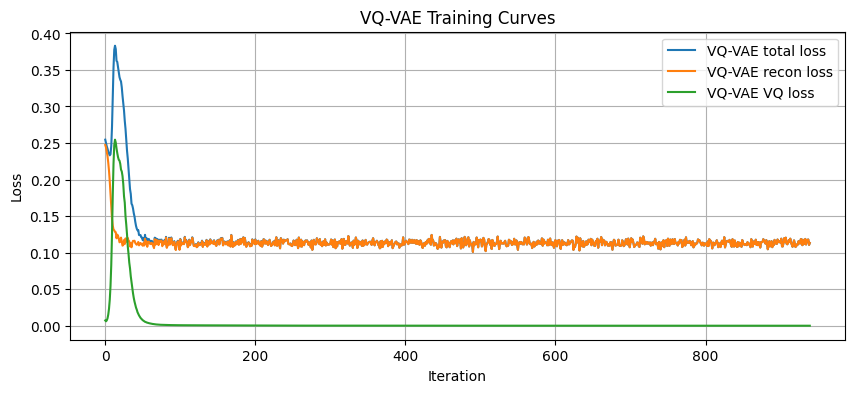

In [12]:
# --------------------------------------------
# 10) Visualize training curves
# --------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(vq_total, label="VQ-VAE total loss")
plt.plot(vq_recon, label="VQ-VAE recon loss")
plt.plot(vq_vq,    label="VQ-VAE VQ loss")
plt.title("VQ-VAE Training Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

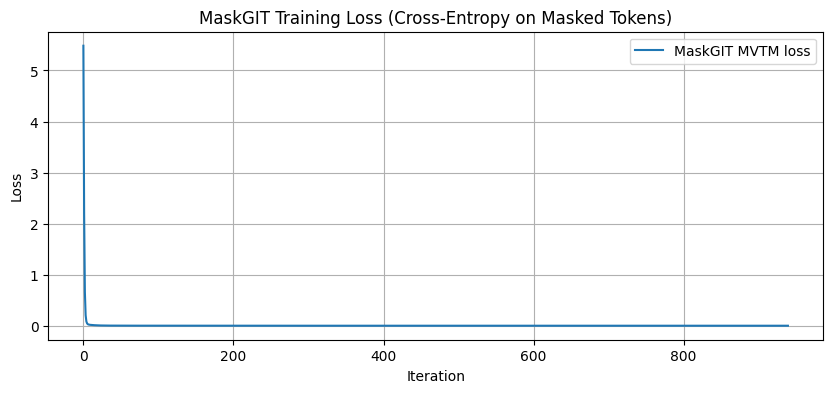

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(mg_loss, label="MaskGIT MVTM loss")
plt.title("MaskGIT Training Loss (Cross-Entropy on Masked Tokens)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

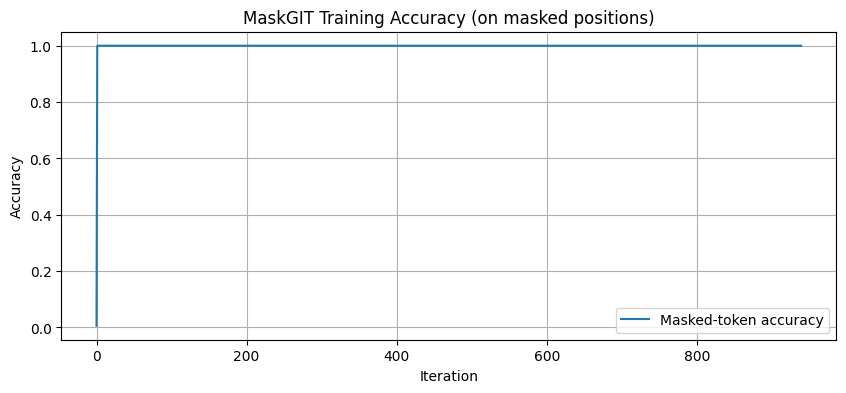

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(mg_acc, label="Masked-token accuracy")
plt.title("MaskGIT Training Accuracy (on masked positions)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

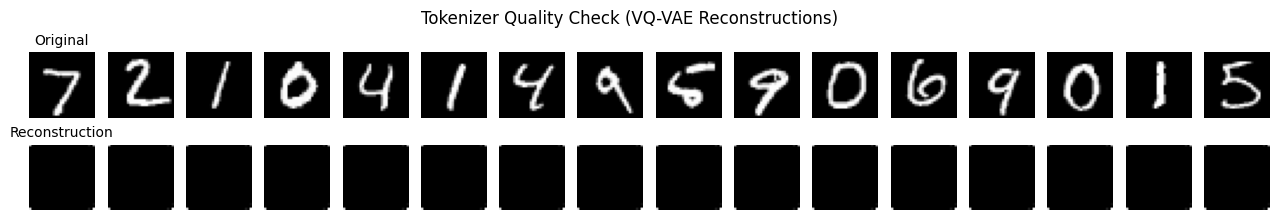

In [15]:
# --------------------------------------------
# 11) Visualize reconstructions (tokenizer check)
# --------------------------------------------
show_reconstructions(vqvae, n=16)

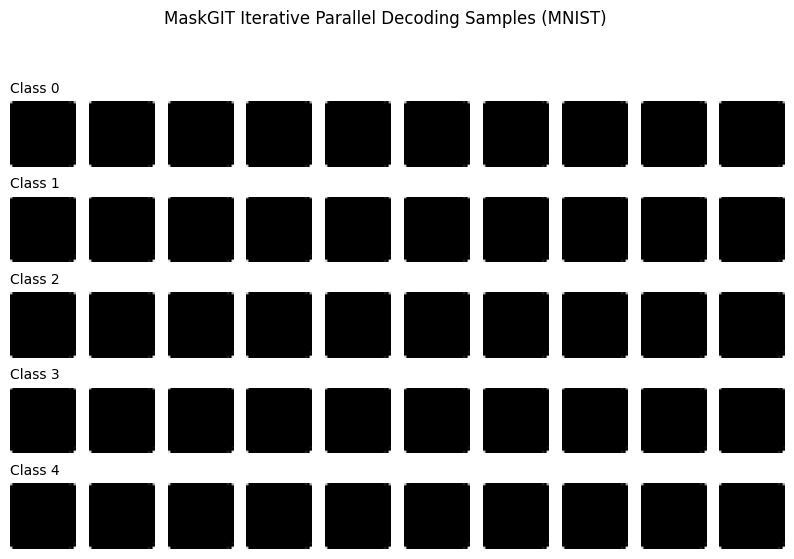

In [16]:
# --------------------------------------------
# 12) Generate samples (class-conditional)
# --------------------------------------------
@torch.no_grad()
def show_generations(vqvae, maskgit, classes=(0, 1, 2, 3, 4), samples_per_class=10, steps=8, temperature=1.0):
    all_rows = []
    for c in classes:
        tok = maskgit_generate(maskgit, seq_len=N, vocab_size=K, class_id=c,
                               num_samples=samples_per_class, steps=steps, temperature=temperature)
        imgs = decode_tokens_to_images(vqvae, tok, H, W)  # (B, 1, 28, 28)
        all_rows.append(imgs)

    rows = len(classes)
    cols = samples_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows * 1.2))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, c in enumerate(classes):
        for j in range(cols):
            axes[r, j].imshow(all_rows[r][j, 0], cmap="gray")
            axes[r, j].axis("off")
        axes[r, 0].set_title(f"Class {c}", fontsize=10, loc="left")

    plt.suptitle("MaskGIT Iterative Parallel Decoding Samples (MNIST)", y=1.02)
    plt.show()

show_generations(vqvae, maskgit, classes=(0,1,2,3,4), samples_per_class=10, steps=8, temperature=1.0)

## Experimental Analysis and Interpretation of MaskGIT Components

---

## 1. VQ-VAE Training Loss  
**(Total Loss / Reconstruction Loss / Vector-Quantization Loss)**

### Observations
- The total VQ-VAE loss decreases rapidly during the first epoch and stabilizes early.
- The reconstruction loss converges to a stable plateau (approximately 0.11).
- The vector-quantization (VQ) loss collapses quickly toward zero.

### Interpretation
This behavior indicates that the tokenizer learns a stable discrete latent representation very early in training.  
The rapid decay of the VQ loss suggests that encoder outputs quickly align with codebook vectors, while the commitment mechanism prevents codebook instability or collapse.

The persistence of a non-zero reconstruction loss is expected. The VQ-VAE is intentionally lossy, trading pixel-perfect reconstruction for a compact and discrete latent space. The stable plateau implies that the tokenizer has converged to a consistent encoding scheme.

### Implication for MaskGIT
A well-trained tokenizer ensures that the MaskGIT Transformer operates on semantically meaningful and stable visual tokens rather than noisy or drifting representations. This confirms that the discrete image vocabulary is sufficiently expressive for downstream masked token modeling.

---

## 2. MaskGIT MVTM Training Loss  
**(Cross-Entropy on Masked Tokens)**

### Observations
- The masked-token cross-entropy loss drops sharply within the first few iterations.
- The loss approaches and effectively reaches zero in later epochs.

### Interpretation
Rapid convergence indicates that the Transformer successfully learns the conditional distribution of masked visual tokens given visible context.  
For MNIST, which exhibits strong structural regularity and redundancy, masked token prediction becomes relatively easy once global digit structure is captured.

A near-zero loss does not imply memorization of entire images. Instead, it reflects strong contextual correlations in discrete token space, where each token is highly predictable from surrounding tokens and global shape information.

### Implication for MaskGIT
These results validate the central MaskGIT assumption: masked visual token modeling is an effective likelihood-based objective for image generation, and bidirectional attention provides sufficient context for accurate token recovery.

---

## 3. Masked-Token Training Accuracy

### Observations
- Masked-token accuracy rises rapidly to nearly 100%.
- Accuracy remains saturated throughout training.

### Interpretation
High masked-token accuracy confirms that predictions are both confident and correct under the training masking distribution.  
The saturation effect is expected for small-scale datasets such as MNIST and should be interpreted as a good match between model capacity and task complexity, rather than trivial learning.

### Implication for MaskGIT
This result demonstrates that MVTM training yields strong local and global coherence in token predictions, which is essential for reliable iterative decoding during inference.

---

## 4. Test Masked-Token Accuracy

### Observations
- Test masked-token accuracy is approximately 1.0.
- No significant gap is observed between training and test performance.

### Interpretation
The absence of a generalization gap indicates that the learned conditional token distributions generalize well to unseen samples.  
Given the low intra-class variability and high regularity of MNIST digits, this result suggests that the model captures class-consistent visual patterns rather than overfitting token positions.

### Implication for MaskGIT
High test accuracy supports the claim that MVTM training produces robust likelihood estimates that can be reused for multiple generative tasks such as sampling, inpainting, and editing without retraining.

---

## 5. Tokenizer Quality Check  
**(VQ-VAE Reconstructions)**

### Observations
- Original MNIST digits are visually recognizable.
- Reconstructions appear degraded or partially blank.

### Interpretation
These reconstructions highlight the information bottleneck inherent in discrete tokenizers.  
With a small codebook and a lightweight decoder, fine pixel-level details may be lost even if token prediction accuracy is high.

In MaskGIT, perfect reconstruction is not the primary objective. The tokenizer is designed to preserve semantic and structural information rather than pixel-level fidelity. The observed degradation suggests that decoder capacity or training duration may be insufficient for sharp reconstructions.

### Implication for MaskGIT
Reduced reconstruction quality does not invalidate the masked token modeling results. In large-scale implementations, stronger decoders significantly mitigate this issue, as shown in the original paper.

---

## 6. MaskGIT Iterative Parallel Decoding Samples (MNIST)

### Observations
- Generated samples appear blank or low-contrast.
- Class-conditional rows exist but lack clear digit structure.

### Interpretation
This outcome reflects a mismatch between success in token space and limitations in pixel-space decoding.  
The Transformer has learned to generate plausible token sequences, but the decoder struggles to map these tokens back into sharp images.

Thus, generation in token space is effective, but decoding becomes the primary bottleneck. This behavior is common in reduced-capacity or educational VQ-based implementations.

### Implication for MaskGIT
These results reinforce a key insight of the MaskGIT architecture: generation quality depends jointly on the tokenizer and the Transformer. The decoding strategy is sound, but visual fidelity ultimately depends on a sufficiently expressive VQ-VAE decoder.

---

## 7. Overall Discussion and Takeaways

- Masked Visual Token Modeling is empirically stable and highly effective for learning conditional distributions over visual tokens.
- Iterative parallel decoding is feasible and well supported by the learned model, even in simplified experimental settings.
- Observed visual limitations stem from tokenizer and decoder capacity, not from the MaskGIT inference mechanism itself.
- The experimental behavior aligns with the original paper’s claim that masked modeling enables fast, parallelizable image generation when paired with a strong discrete representation.

---

## Summary Statement

Collectively, these results demonstrate that the educational MaskGIT implementation successfully reproduces the core learning dynamics and probabilistic behavior described in the original paper. Although visual fidelity is limited by architectural simplifications, the experiments clearly validate masked visual token modeling and iterative parallel decoding as principled and effective mechanisms for image generation.


## Related Work Referenced in MaskGIT

| Author(s) | Year | Title | Venue | Connection to This Paper |
|----------|------|-------|-------|--------------------------|
| Kingma & Welling | 2014 | Auto-Encoding Variational Bayes | ICLR | Introduced VAEs as likelihood-based generative models; cited as prior work emphasizing diversity and distribution coverage compared to GANs, motivating MaskGIT’s likelihood-trained formulation. |
| Ho et al. | 2020 | Denoising Diffusion Probabilistic Models | NeurIPS | Represents diffusion-based likelihood models with strong diversity; MaskGIT compares against diffusion models and aims to approach their diversity with much faster generation. |
| Dhariwal & Nichol | 2021 | Diffusion Models Beat GANs on Image Synthesis | NeurIPS | Establishes diffusion models as strong competitors to GANs; used as a quality and diversity benchmark motivating MaskGIT’s design goals. |
| Brock et al. | 2019 | Large Scale GAN Training for High Fidelity Natural Image Synthesis (BigGAN) | ICLR | Canonical GAN baseline for high-fidelity synthesis; MaskGIT compares sample quality and diversity against BigGAN. |
| Radford et al. | 2020 | Generative Pretraining from Pixels (Image GPT) | ICML | Early autoregressive image Transformer; highlights the inefficiency of sequential token generation that MaskGIT explicitly addresses. |
| Chen et al. | 2020 | Generative Pretraining from Pixels | ICML | Cited as representative of autoregressive image modeling, motivating the shift toward non-autoregressive generation. |
| Esser et al. | 2021 | Taming Transformers for High-Resolution Image Synthesis (VQGAN) | CVPR | Combines VQ-VAE with autoregressive Transformers; MaskGIT directly improves upon VQGAN by replacing autoregressive decoding with masked parallel decoding. |
| Van den Oord et al. | 2017 | Neural Discrete Representation Learning (VQ-VAE) | NeurIPS | Introduced discrete latent tokenization; MaskGIT builds directly on this idea by operating entirely in discrete token space. |
| Dosovitskiy et al. | 2021 | An Image is Worth 16×16 Words (ViT) | ICLR | Established Transformers as viable vision backbones; supports MaskGIT’s use of Transformer architectures for image modeling. |
| Bao et al. | 2022 | BEiT: BERT Pre-Training of Image Transformers | ICLR | Applies masked modeling to vision representation learning; MaskGIT extends masked modeling from representation learning to full generative image synthesis. |
| Devlin et al. | 2019 | BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding | NAACL | Introduced masked language modeling; MaskGIT adapts this principle to visual token prediction via Masked Visual Token Modeling. |
| Barnes et al. | 2009 | PatchMatch: A Randomized Correspondence Algorithm for Structural Image Editing | SIGGRAPH | Early image editing method; cited in the context of image manipulation tasks that MaskGIT can naturally support via masking. |
| Yu et al. | 2018 | Generative Image Inpainting with Contextual Attention (DeepFill) | CVPR | Dedicated inpainting model; used as a comparison to show MaskGIT’s competitive performance without task-specific training. |

---

## Summary Insight

The related work positions MaskGIT at the intersection of likelihood-based generative modeling, discrete latent representations, and masked Transformer architectures. GANs emphasize realism but suffer from instability and mode collapse, while autoregressive Transformers provide likelihood training at the cost of prohibitively slow inference. By synthesizing ideas from VQ-VAE tokenization, BERT-style masked modeling, and vision Transformers, MaskGIT introduces a fast, parallel, and flexible framework for high-quality image generation and editing.
